## Xマッチからブキ偏差値を求める

In [32]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import seaborn as sns
from scipy.stats import boxcox
from packages.japanize import japanize
import packages.db as db
from packages.i18n import Locale, Translator
import packages.image as image
import packages.definitions as d
import packages.utils as u
import packages.visualize as v

locale = Locale.JA
lobby = d.Lobby.XMATCH
date_from = dt.date(2023, 6, 17)
date_to = dt.date(2023, 6, 30)
battles = db.load_battles(lobby=lobby, date_from=date_from, date_to=date_to)

In [33]:
prev_date_from = dt.date(2023, 5, 18)
prev_date_to = dt.date(2023, 5, 31)
prev_battles = db.load_battles(lobby=lobby, date_from=prev_date_from, date_to=prev_date_to)
prev_players = u.to_players(prev_battles)

バトル数: 19571


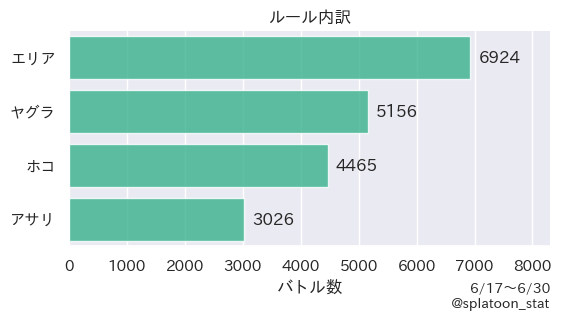

パワー不明バトル数: 1636


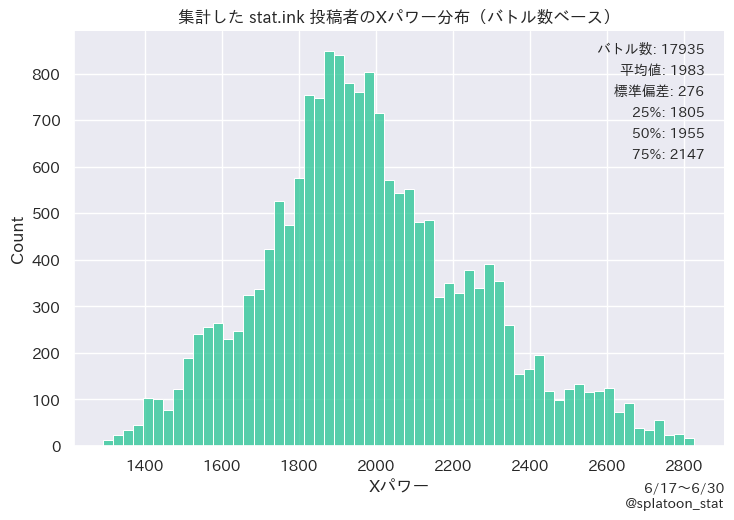

In [34]:
v.xmatch_mode_breakdown(battles=battles, locale=locale)
v.xmatch_power_distribution(battles=battles, locale=locale)

In [35]:
players = u.to_players(battles)

### ブキ統計値を求める

- ブキ使用率
- ブキ使用者の平均Xパワー

In [36]:
k_coef = 0.45
theta = np.pi / 2 * k_coef
vec_strength = np.array([np.cos(theta), np.sin(theta)])

def create_weapon_stat(players: pd.DataFrame) -> pd.DataFrame:
    usage = players.groupby("mode")["weapon"].value_counts(normalize=True).to_frame("usage")
    power = players.groupby(["mode", "weapon"])["power"].mean().to_frame("power")

    def standardize(series: pd.Series) -> pd.Series:
        return (series - series.mean()) / series.std()

    weapon_stat = pd.concat([usage, power], axis=1)
    weapon_stat["usage-bc"] = weapon_stat.groupby("mode")["usage"].transform(lambda x: boxcox(x)[0])
    weapon_stat["usage-z"] = weapon_stat.groupby("mode", group_keys=False)["usage-bc"].apply(standardize)
    weapon_stat["power-z"] = weapon_stat.groupby("mode", group_keys=False)["power"].apply(standardize)

    def calc_dot(series: pd.Series) -> float:
        vec_weapon = np.array([series["usage-z"], series["power-z"]])
        return np.dot(vec_weapon, vec_strength)

    weapon_stat["strength"] = weapon_stat.apply(calc_dot, axis=1)
    weapon_stat["strength-z"] = standardize(weapon_stat["strength"])
    weapon_stat["strength-t"] = weapon_stat["strength-z"].map(lambda x: x * 10 + 50)
    return weapon_stat

def create_strength_map(weapon_stat: pd.DataFrame) -> pd.DataFrame:
    strength_map = weapon_stat.reset_index().pivot(index="weapon", columns="mode", values="strength-t").reindex(d.MODE_ORDER, axis=1)
    strength_map["mean"] = strength_map.mean(axis=1)
    strength_map = strength_map.sort_values("mean", ascending=False)
    return strength_map

def create_strength_map_difference(weapon_stat: pd.DataFrame, prev_weapon_stat: pd.DataFrame) -> pd.DataFrame:
    strength_map = create_strength_map(weapon_stat)
    prev_strength_map = create_strength_map(prev_weapon_stat)

    strength_map["diff"] = strength_map["mean"] - prev_strength_map["mean"]
    return strength_map

In [37]:
weapon_stat = create_weapon_stat(players)
prev_weapon_stat = create_weapon_stat(prev_players)
strength_map_difference = create_strength_map_difference(weapon_stat, prev_weapon_stat)
strength_map_difference

mode,area,yagura,hoko,asari,mean,diff
weapon,,,,,,
kugelschreiber,72.632524,65.447048,65.818458,67.545692,67.860931,-1.863429
bottlegeyser,67.236396,67.892265,66.047433,69.947789,67.780971,3.655881
sharp,69.467564,65.400473,63.807171,66.958415,66.408406,3.893623
bucketslosher,67.443830,66.204435,65.207500,63.116971,65.493184,1.932723
longblaster,58.246638,69.170033,67.366621,62.330156,64.278362,2.734184
...,...,...,...,...,...,...
jetsweeper,36.924275,30.897888,32.774281,31.666210,33.065664,-1.560524
carbon,28.223124,45.156077,30.624908,25.781499,32.446402,3.520367
rapid_elite,29.432264,31.344613,45.377154,22.869714,32.255936,-14.249920


### 可視化する

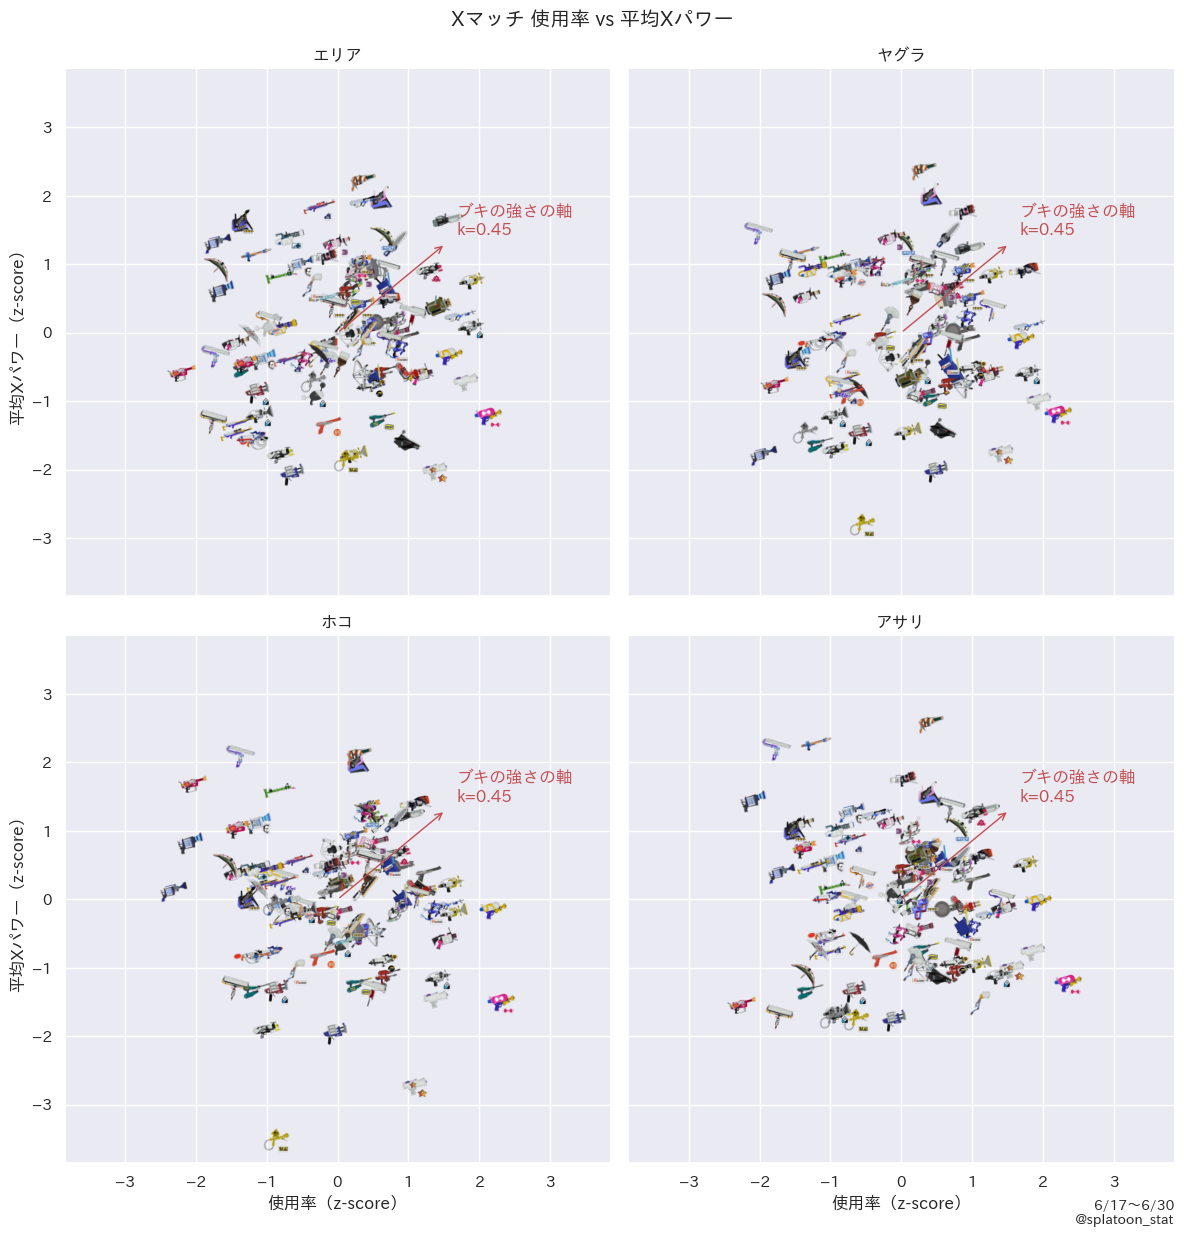

In [38]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("usage", "使用率（z-score）", "Usage (z-score)")
i18n.add("power", "平均Xパワー（z-score）", "X Power Avg. (z-score)")
i18n.add("vector", "ブキの強さの軸", "Assumed axis\nof weapon strength")
i18n.add("title", "${lobby} 使用率 vs 平均Xパワー", "Usage vs X Power Avg. in ${lobby}")

value_range = max(weapon_stat[["usage-z", "power-z"]].abs().max().max() * 1.1, 3)

g = sns.relplot(
    data=weapon_stat,
    x="usage-z",
    y="power-z",
    col="mode",
    col_wrap=2,
    col_order=d.MODE_ORDER,
    marker="",
    height=6,
)
g.fig.suptitle(
    i18n.t("title", lobby=i18n.t(lobby.value)),
    verticalalignment="bottom",
    y=1,
)
g.set(
    xlabel=i18n.t("usage"),
    ylabel=i18n.t("power"),
    xlim=(-value_range, value_range),
    ylim=(-value_range, value_range),
)

for i, ax in enumerate(g.axes):
    mode = d.MODE_ORDER[i]
    ax.set(title=i18n.t(mode))

    for _, row in weapon_stat.loc[mode].iterrows():
        weapon = row.name
        xvalue = row["usage-z"]
        yvalue = row["power-z"]
        image_path = image.get_image_path(weapon)
        im = plt.imread(image_path)
        img = OffsetImage(im, zoom=0.65)
        img.image.axes = ax
        ab = AnnotationBbox(img, (xvalue, yvalue), frameon=False, pad=0)
        ax.add_artist(ab)

    # ブキの強さの軸のベクトルを表示する
    ax.annotate("", (0, 0), xytext=[x * 2 for x in vec_strength], color="r", arrowprops=dict(arrowstyle="<-", connectionstyle="arc3", color="r"))
    ax.annotate(f"{i18n.t('vector')}\nk={k_coef}", (0, 0), xytext=[x * 2.2 for x in vec_strength], color="r")

    if i == 3:
        u.credit(ax, g.fig, i18n.t_data_duration(battles))

plt.show()

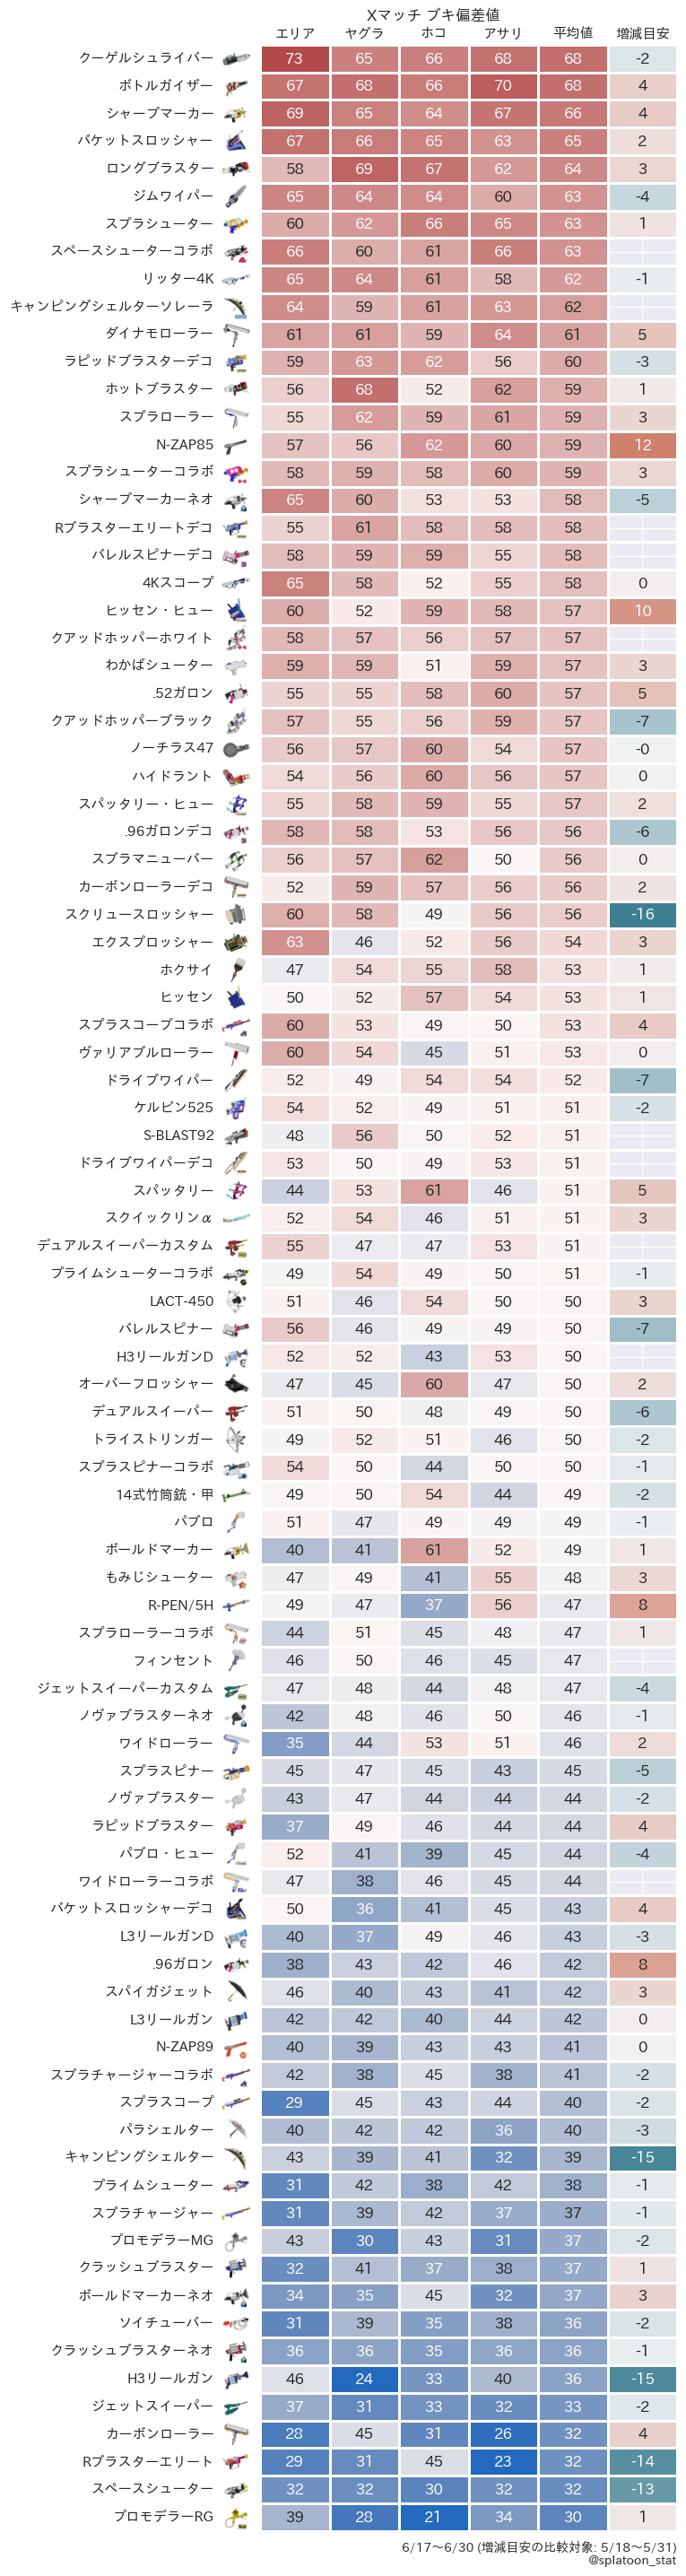

In [39]:
sns.set_theme()
japanize()

i18n = Translator(locale)
i18n.add("title", "${lobby} ブキ偏差値", "Weapon Strehgth (t-score) in ${lobby}")
i18n.add("strength", "ブキ偏差値", "Usage Strength (t-score)")
i18n.add("diff", "増減目安", "Gain")
i18n.add("duration", "${duration} (増減目安の比較対象: ${prev_duration})", "${duration} (Gain vs. ${prev_duration})")

fig, axes = plt.subplots(
    figsize=(6, len(strength_map_difference) * 0.4),
    ncols=2,
    gridspec_kw={"width_ratios": [5, 1], "wspace": 0},
)

# 偏差値
ax = axes[0]
sns.heatmap(
    data=strength_map_difference.iloc[:,:5],
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.color_palette("vlag", as_cmap=True),
    center=50,
    vmin=50-25,
    vmax=50+25,
    linewidths=2,
    ax=ax,
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
yticklabels = [i18n.t(x) for x in ykeys]

ax.set(
    title=i18n.t("title", lobby=i18n.t(lobby.value)),
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
)
ax.yaxis.set_ticklabels(yticklabels, x=-0.12)

for i, key in enumerate(ykeys):
    image_path = image.get_image_path(key)
    img = OffsetImage(plt.imread(image_path), zoom=.65)
    img.image.axes = ax
    ab = AnnotationBbox(img, (0, 0), xybox=(-0.35, i + 0.5), frameon=False)
    ax.add_artist(ab)

# 偏差値増減
value_range = max(strength_map_difference["diff"].abs().max(), 1)
ax = axes[1]
sns.heatmap(
    data=strength_map_difference.iloc[:,5:],
    annot=True,
    fmt=".0f",
    cbar=False,
    cmap=sns.diverging_palette(220, 20, as_cmap=True),
    linewidths=2,
    center=0,
    vmin=-value_range,
    vmax=value_range,
    ax=ax,
)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")
ax.tick_params(length=0)

xkeys, ykeys = u.get_ax_ticklabels(ax)
xticklabels = [i18n.t(x) for x in xkeys]
ax.set(
    xlabel="",
    ylabel="",
    xticklabels=xticklabels,
    yticklabels="",
)

u.credit(ax, fig, i18n.t("duration", duration=i18n.t_data_duration(battles), prev_duration=i18n.t_data_duration(prev_battles)), 0.3)

plt.show()